# Transformers in practice

<hr style="border:2px solid gray">

# Index <a id='index'></a>
1. [Introduction](#intro)
1. [Transformer code blocks](#code-blocks)
1. [List reversing, continued](#list-reverse)
1. [LHC jet tagging using transformers](#jet-tagging)


**Note**: to make the most of this notebook, being able to run on your GPU for training is important. Make sure you are running this notebook in the container for GPU usage you were shown earlier in the course (if you weren't able to get this working or can't remember how to do it, adaptations for exercises will be given to ensure code doesn't take too long to run).

<hr style="border:2px solid gray">

# Introduction <a id='intro'></a> [^](#index)

Now that you've seen how transformers work and how we can implement them using PyTorch, we will try approaching a few different problems using transformers, and explore some of the individual components in a bit more detail. This includes:

* Visualising attention outputs for our list reversing example

* Increasing the number of heads to handle a more complex list reversing problem

* Demonstrating the performance improvement using transformers vs standard neural networks for an LHC jet tagging problem

The next section will give you code blocks for the parts we need for our transformer architectures, which you can use for the rest of the notebook.

<hr style="border:2px solid gray">

# Transformer code blocks <a id='code-blocks'></a> [^](#index)

While you will have written your own code last time, for this notebook use the code blocks in this section. The majority of them will be the same as in the worked example version of the previous notebook, with the exception of the MultiHeadAttention class, which here has an option to return the attention output as well as the final output.

We will also define our own version of `scaled_dot_product_attention` here, as the PyTorch implementation can only return the output, whereas we want to be able to visualise the attention weights. This implementation is based on the example given in the [documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html), with added functionality to return the attention weights. We will call this new class `SDPA`.

Firstly, our standard set of imports:

In [286]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

Now, we will define `SDPA`, `MultiHeadAttention`, and `PositionalEncoding`:

In [287]:
# Mostly copied from https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html,
# but modified to return attention weights as well.
def SDPA(query, key, value, attn_mask=None, dropout_p=0.0, is_causal=False, scale=None):
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias = attn_mask + attn_bias

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight @ value, attn_weight


In [288]:
# same as worked example of previous notebook, but modified to use custom SDPA function
# and to return attention weights if needed.
class MultiHeadAttention(nn.Module):
    def __init__(self, E_q, E_k, E_v, d_model, num_heads):
        super().__init__()
        # Require embed_dim  = dim_per_head * num_heads i.e. divisible by num_heads
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        # Define projections of queries, keys, and values
        self.q_proj = nn.Linear(E_q, d_model)
        self.k_proj = nn.Linear(E_k, d_model)
        self.v_proj = nn.Linear(E_v, d_model)
        # Define output projection
        out_dim = E_q
        self.out_proj = nn.Linear(d_model, out_dim)
        # Define dimensions per head
        self.d_head = d_model // num_heads
        

    def forward(self, queries, keys, values, attn_mask = None, is_causal = False, return_attn_weights = False):
        Q = self.q_proj(queries)
        K = self.k_proj(keys)
        V = self.v_proj(values)
        # Reshape to correct shapes for scaled_dot_product_attention
        Q = Q.unflatten(-1,[self.num_heads, self.d_head]).transpose(1,2) # (N, h, L, d_head)
        K = K.unflatten(-1,[self.num_heads, self.d_head]).transpose(1,2) # (N, h, S, d_head)
        V = V.unflatten(-1,[self.num_heads, self.d_head]).transpose(1,2) # (N, h, S, d_head)
        # Find attention output
        attn_output, attn_weight = SDPA(Q, K, V, attn_mask = attn_mask, is_causal = is_causal)
        attn_output = attn_output.transpose(1,2).flatten(-2)
        # Output projection
        o = self.out_proj(attn_output)
        if return_attn_weights:
            return o, attn_weight
        else:
            return o

In [289]:
# Positional Encoding is the same as before
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        super().__init__()
        # Dropout after adding positional encoding
        self.dropout = nn.Dropout(p=dropout)
        # Create positional encoding matrix up to max_len to save
        # computation time when calling forward()
        position = torch.arange(max_len).unsqueeze(1)
        # equivalent to e^(i*-ln(10000)/d_model) = e^(ln(10000^(-i/d_model))) = 1/10000^(i/d_model)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        # fill even embedding dims with sine, odd embedding dims with cosine
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        # Need to include this line to ensure the positional encoding is transferred
        # to the same device as the model, in case we use GPU
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        
        x = x + self.pe[:,:x.size(1)].view(self.pe.size(0),x.size(1),*[1 for _ in x.shape[2:-1]], self.pe.size(-1))
        return self.dropout(x)

Next, we define `TransformerEncoderLayer`, `TransformerDecoderLayer`, and `TransformerModel`, with additional helper functions to extract attention weights: 

In [290]:
# TransformerEncoderLayer and TransformerDecoderLayer same as in worked example with an
# added utility function for each to get the attention weights for all attention layers
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout = 0.1):
        """
        Initialize a Transformer encoder layer.
        Parameters:
        - d_model: dimension of the model
        - num_heads: number of attention heads
        - d_ff: dimension of the feed-forward network
        - dropout: dropout rate
        """
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout = dropout

        # Attention layer
        self.self_attn = MultiHeadAttention(d_model, d_model, d_model, d_model, num_heads)
        self.attn_dropout = nn.Dropout(dropout)
        self.attn_norm = nn.LayerNorm(d_model)

        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.ffn_norm = nn.LayerNorm(d_model)

    def forward(self, src, src_mask = None, is_causal = False):
        """
        Forward pass of the Transformer encoder layer.
        Parameters:
        - src: input tensor of shape (batch_size, seq_length, d_model)
        - src_mask: mask for the tensor input, to mask out keys that should be excluded
                    from attention calculations
        - is_causal: whether to apply causal masking in self-attention
        """
        x = src
        # Self-attention
        attn_output = self.self_attn(x, x, x, attn_mask = src_mask, is_causal = is_causal)
        x = self.attn_norm(x + self.attn_dropout(attn_output))
        # Feed-forward network
        ffn_output = self.linear2(self.dropout1(self.activation(self.linear1(x))))
        x = self.ffn_norm(x + self.dropout2(ffn_output))
        return x

    def get_attention_maps(self, x, mask = None, is_causal = False):
        _, attn_maps = self.self_attn(x, x, x, attn_mask = mask, is_causal = is_causal, return_attn_weights = True)
        return attn_maps

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout = 0.1):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_ff = d_ff
        self.dropout = dropout

        # Masked self-attention block
        self.self_attn = MultiHeadAttention(d_model, d_model, d_model, d_model, num_heads)
        self.self_attn_dropout = nn.Dropout(p = dropout)
        self.self_attn_norm = nn.LayerNorm(d_model)

        # Cross attention block
        self.cross_attn = MultiHeadAttention(d_model, d_model, d_model, d_model, num_heads)
        self.cross_attn_dropout = nn.Dropout(p = dropout)
        self.cross_attn_norm = nn.LayerNorm(d_model)

        # FFN block
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.ReLU()
        self.ffn_dropout1 = nn.Dropout(p = dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.ffn_dropout2 = nn.Dropout(p = dropout)
        self.ffn_norm = nn.LayerNorm(d_model)

    def forward(self, tgt, enc_out, tgt_mask = None, enc_mask = None, tgt_is_causal = True, enc_out_is_causal = False):
        """
        Forward pass of the Transformer decoder layer.
        
        Parameters:
        - tgt: input tensor of shape (batch_size, seq_length, d_model)
        - enc_out: encoder output tensor of shape (batch_size, enc_seq_length, d_model)
        - src_mask: mask for the src tensor input
        - enc_mask: mask for the encoder output tensor input
        """
        x = tgt
        # Masked self-attention
        self_attn_output = self.self_attn(x, x, x, attn_mask = tgt_mask, is_causal = tgt_is_causal)
        x = self.self_attn_norm(x + self.self_attn_dropout(self_attn_output))
        
        # Cross-attention
        cross_attn_output = self.cross_attn(x, enc_out, enc_out, attn_mask = enc_mask, is_causal = enc_out_is_causal)
        x = self.cross_attn_norm(x + self.cross_attn_dropout(cross_attn_output))
        
        # Feed-forward network
        ffn_output = self.linear2(self.ffn_dropout1(self.activation(self.linear1(x))))
        x = self.ffn_norm(x + self.ffn_dropout2(ffn_output))
        return x
    
    def get_attention_maps(self, tgt, enc_out, tgt_mask = None, enc_mask = None,
                           tgt_is_causal = True, enc_out_is_causal = False):
        _, self_attn_maps = self.self_attn(tgt, tgt, tgt, attn_mask = tgt_mask,
                                          is_causal = tgt_is_causal, return_attn_weights = True)
        _, cross_attn_maps = self.cross_attn(tgt, enc_out, enc_out, attn_mask = enc_mask,
                                            is_causal = enc_out_is_causal, return_attn_weights = True)
        return self_attn_maps, cross_attn_maps

In [291]:
# Full Transformer model, with utility to get attention maps
class TransformerModel(nn.Module):
    def __init__(self, d_vocab, d_model, num_heads, d_ff, num_encoder_layers, num_decoder_layers, dropout = 0.1, max_len = 5000):
        super().__init__()
        self.input_embedding = nn.Embedding(d_vocab, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_len)
        self.encoder = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_encoder_layers)
        ])
        self.decoder = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, dropout) 
            for _ in range(num_decoder_layers)
        ])
        self.output_linear = nn.Linear(d_model, d_vocab)

    def forward(self, src, tgt, src_mask = None, tgt_mask = None, src_is_causal = False, tgt_is_causal = True):
        # Embed and add positional encoding to source
        src = self.input_embedding(src)
        src = self.pos_encoder(src)
        # Pass through encoder layers
        for layer in self.encoder:
            src = layer(src, src_mask, src_is_causal)
        enc_out = src
        # Embed and add positional encoding to target
        tgt = self.input_embedding(tgt)
        tgt = self.pos_encoder(tgt)
        # Pass through decoder layers
        for layer in self.decoder:
            tgt = layer(tgt, enc_out, tgt_mask, None, tgt_is_causal, src_is_causal)
        # Output linear transformation & softmax
        output = self.output_linear(tgt)
        output = F.softmax(output, dim=-1)
        return output

    def get_attention_maps(self, src, tgt, src_mask = None, tgt_mask = None, src_is_causal = False, tgt_is_causal = True):
        # Get attention maps from all encoder and decoder layers
        enc_self_attn_maps = []
        dec_self_attn_maps = []
        dec_cross_attn_maps = []
        
        # Embed and add positional encoding to source
        src = self.input_embedding(src)
        src = self.pos_encoder(src)
        # Pass through encoder layers
        for layer in self.encoder:
            attn_map = layer.get_attention_maps(src, src_mask, src_is_causal)
            enc_self_attn_maps.append(attn_map)
            src = layer(src, src_mask, src_is_causal)
        enc_out = src
        
        # Embed and add positional encoding to target
        tgt = self.input_embedding(tgt)
        tgt = self.pos_encoder(tgt)
        # Pass through decoder layers
        for layer in self.decoder:
            self_attn_map, cross_attn_map = layer.get_attention_maps(tgt, enc_out, tgt_mask, None, tgt_is_causal, src_is_causal)
            dec_self_attn_maps.append(self_attn_map)
            dec_cross_attn_maps.append(cross_attn_map)
            tgt = layer(tgt, enc_out, tgt_mask, None, tgt_is_causal, src_is_causal)
        
        return enc_self_attn_maps, dec_self_attn_maps, dec_cross_attn_maps    


Finally, we also include the CosineWarmUp learning rate scheduler:

In [292]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + math.cos(math.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

<hr style="border:2px solid gray">

# List reversing, continued


Continuing the list reversing example from before, we wil start by training a model in the same way as last time, and then we will look at the attention weights to see if they tell us anything interesting about what the model has learned. This roughly follows the [UvA tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html).

To start with, we will reproduce the dataset code and provide a model definition:

In [293]:
# Define dataset generation
class ReverseDataset(data.Dataset):
    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels
    
# Create dataset
torch.manual_seed(0)
n_categories = 10
seq_length = 16
dataset = ReverseDataset(num_categories=n_categories, seq_len=seq_length, size=60000)

In [294]:
# Split to train/test datasets and create DataLoaders:
torch.manual_seed(0)

n_train = 50000
n_test = 10000
train_dataset, test_dataset = data.random_split(dataset, [n_train, n_test])

train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last = True)
test_loader = data.DataLoader(test_dataset, batch_size=128)

In [295]:
# ReversePredictor class definition, modified to have a get_attention_maps method
class ReversePredictor(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, n_classes, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_model*2, dropout) 
            for _ in range(n_layers)
        ])
        self.fc_out = nn.Linear(d_model, n_classes)

    def forward(self, src):
        x = self.embedding(src)
        x = self.pos_encoder(x)
        for layer in self.transformer:
            x = layer(x)
        out = self.fc_out(x)
        return out
    
    def get_attention_maps(self, src):
        attn_maps = []
        x = self.embedding(src)
        x = self.pos_encoder(x)
        for layer in self.transformer:
            attn_map = layer.get_attention_maps(x)
            attn_maps.append(attn_map)
            x = layer(x)
        return attn_maps
    
# Instantiate your model
model = ReversePredictor(
    input_dim=n_categories,
    d_model = 32,
    n_heads = 1,
    n_classes = n_categories,
    n_layers = 1,
    dropout = 0.0)

<div style="background-color:#C2F5DD">

Replicate your training loop from the previous notebook to train the model. Use the same training parameters, as follows:

* Train for 10 epochs

* The Adam optimizer, with a learning rate of 0.001

* CosineWarmUp learning rate scheduler, with `warmup` = 50 and `max_iters` = `n_epochs` $\times$ `len(train_loader)`

* Use CrossEntropyLoss

Your training loop should be the same as normal, with the exception of stepping the learning rate scheduler after processing all batches in an epoch. 

**Note**: when we get the output from the model it will have shape (`batch_size`, `seq_length`, `n_categories`), and the target will have shape (`batch_size`, `seq_length`). `CrossEntropyLoss` requires the model output have shape (`batch_size`, `n_categories`, `seq_length`), so make sure to transpose the correct axes before passing through the loss function.



In [296]:
# Your training code here

n_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineWarmupScheduler(optimizer, warmup=50, max_iters = n_epochs * len(train_loader))
criterion = nn.CrossEntropyLoss()

def train_epoch(model, train_loader, optimizer, scheduler, criterion):
    model.train()
    total_loss = 0
    n_correct = 0
    for _, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.transpose(1,2), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_correct += (output.argmax(dim=-1) == targets).sum().item()
    scheduler.step()
    accuracy = n_correct / (len(train_loader.dataset) * seq_length)
    return total_loss / len(train_loader), accuracy

train_losses = []
for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, criterion)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2%}')

Epoch 1/10, Train Loss: 2.4366, Train Accuracy: 9.80%
Epoch 2/10, Train Loss: 2.3912, Train Accuracy: 9.88%
Epoch 3/10, Train Loss: 2.3293, Train Accuracy: 10.85%
Epoch 4/10, Train Loss: 2.2848, Train Accuracy: 14.02%
Epoch 5/10, Train Loss: 2.1950, Train Accuracy: 20.39%
Epoch 6/10, Train Loss: 1.8657, Train Accuracy: 34.12%
Epoch 7/10, Train Loss: 1.2248, Train Accuracy: 54.42%
Epoch 8/10, Train Loss: 0.6454, Train Accuracy: 75.88%
Epoch 9/10, Train Loss: 0.3021, Train Accuracy: 89.62%
Epoch 10/10, Train Loss: 0.1430, Train Accuracy: 94.74%


Now that we have a trained model, let's visualise the attention weights for our encoder self-attention, to see what the model has learned. First, we need to get the attention maps out from our trained model, for one sample from our test dataset:

In [297]:
sample, target = test_dataset[0]
attn_maps = model.get_attention_maps(sample.unsqueeze(0)) # need unsqueeze to add batch dimension

Now, let's define a function to visualise attention maps:

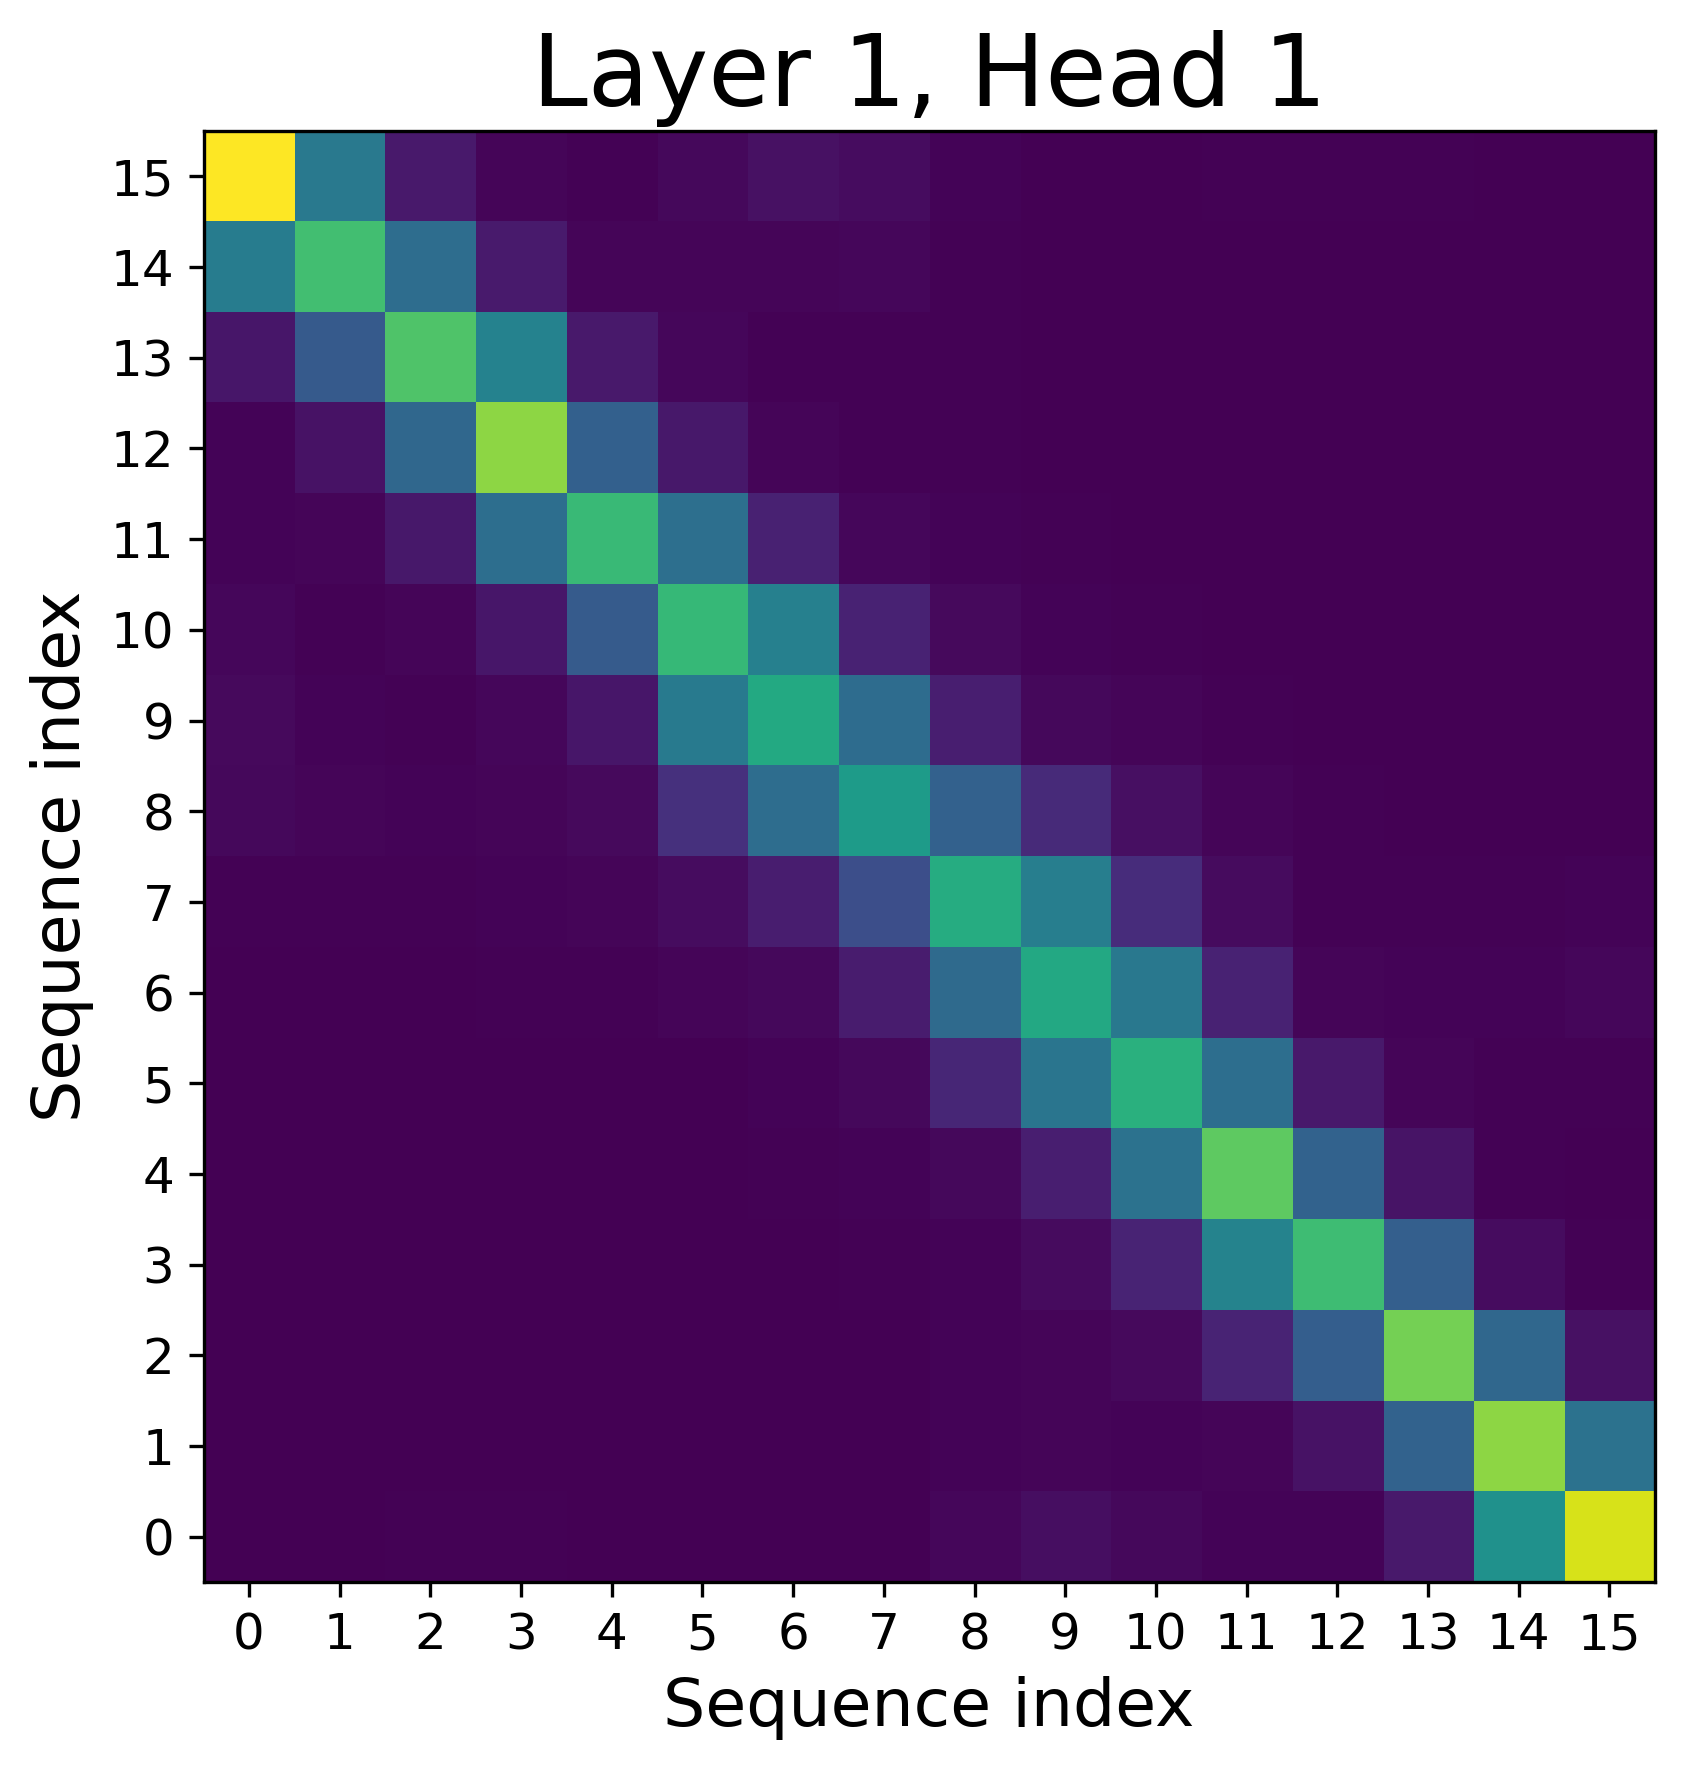

In [298]:
import matplotlib.pyplot as plt

def plot_attention_map(attn_maps, input_data, **plot_kwargs):
    attn_maps = [m.detach().squeeze(0) for m in attn_maps] # remove batch dimension
    if input_data is not None:
        input_data = input_data.detach().cpu().numpy()
    else:
        input_data = list(range(attn_maps[0].shape[-1]))
    
    num_heads, seq_length, _ = attn_maps[0].shape
    num_layers = len(attn_maps)
    fig_size = 6 if num_heads == 1 else 4.5
    fig, axs = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size), dpi = 300)
    if num_layers == 1:
        axs = [axs]
    if num_heads == 1:
        axs = [[a] for a in axs]
    for row in range(num_layers):
        for col in range(num_heads):
            ax = axs[row][col]
            im = ax.imshow(attn_maps[row][col].view(seq_length, seq_length), **plot_kwargs, origin = 'lower', vmin = 0)
            ax.set_xticks(list(range(seq_length)))
            ax.set_xticklabels(list(range(seq_length)), fontsize = 12)
            ax.set_yticks(list(range(seq_length)))
            ax.set_yticklabels(list(range(seq_length)), fontsize = 12)
            ax.set_xlabel('Sequence index',fontsize = 16)
            ax.set_ylabel('Sequence index',fontsize = 16)
            ax.set_title(f'Layer {row + 1}, Head {col + 1}',fontsize = 24)
    fig.tight_layout()
    plt.show()

plot_attention_map(attn_maps, sample, cmap='viridis')
    

What can we see from this? Consider sequence index 0 on the x-axis; the highest attention weight for that sequence element is for the sequence element at index 15, i.e. the opposite end of the list. 

In fact, the off-diagonal structure (i.e. on the diagonal from top-left to bottom-right) tells us for a given sequence element, the highest attention weight is for the sequence element in the reversed index, exactly as we would hope to see for this problem. This gives us a nice view of how attention works and what it might mean physically, although in general attention weights will be much less obviously interpretable.

<hr style="border:2px solid gray">

# LHC jet tagging using transformers <a id='jet-tagging'></a> [^](#index)



Now that we've seen an example of using transformers, let's try tackling a real-life problem from particle physics.

At the LHC, the products of particle collisions are not directly detected, but instead form jets of additional particles. One of the key stages in analysis of data collected is to identify what type of particle initiated a jet, so individual particle events can be isolated for analyses. 

To identify the original particle, the information we have to work with is generally some characteristics of the jet, and measurements of the particles produced by the jet. 

To tackle this problem, we will work with a dataset of high transverse momentum (i.e. high momentum perpendicular to the beamline at the LHC) jets produced by simulations of proton-proton collisions. This dataset is a common benchmark dataset for fast ML applications, necessary for triggering to decide what data should be kept or not.

We will treat this data like a sequence of particles from the jet, with three features per particle describing the magnitude of the particle momentum and its direction of motion. While we have up to 150 particles available per jet, we will use a maximum of 32. You can read more about this dataset in the [corresponding paper](https://arxiv.org/pdf/1709.08705).

The slide below is from a presentation using a transformer model with this dataset for jet tagging, given by Lauri Laatu at EPS-HEP 2025. You can see the presentation slides [here](https://indico.in2p3.fr/event/33627/contributions/154676/).

<center>
<img src='jet-tag-slide.png' width=900/>
</center>

To start with, let's load in the data and inspect one sample:

In [330]:
import numpy as np

jet_tag_data = np.load('jet_tag_data.npy', allow_pickle=True).item()
train_dataset = data.TensorDataset(torch.from_numpy(jet_tag_data['train']['X'].astype(np.float32)), torch.from_numpy(jet_tag_data['train']['y'].astype(np.int64)))
test_dataset = data.TensorDataset(torch.from_numpy(jet_tag_data['test']['X'].astype(np.float32)), torch.from_numpy(jet_tag_data['test']['y'].astype(np.int64)))

In [331]:
src, tgt = test_dataset[0]
print(src.shape, tgt)

torch.Size([32, 3]) tensor(1)


Each data sample is a sequence of length 32, where each sequence element has 3 features. The target is a numerical encoding of the jet class. For simplicity, we have restricted this data sample to just two classes, corresponding to top quark and QCD events.

<div style="background-color:#C2F5DD">

Now that we have the data loaded in, you should define DataLoaders for the train and test datasets respectively. Use a batch size of 128 and make sure the train DataLoader shuffles the data.

In [332]:
# Your code here

batch_size = 128
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size)

<div style="background-color:#C2F5DD">

Now, let's train a transformer encoder on this data. Use the following architecture for your transformer:

* Input embedding layer to $d_\text{model}$ = 16; note because we have continuous values as our features, this needs to be a `nn.Linear` layer rather than `nn.Embedding`

* Add positional encodings

* 2 encoder layers, each with 2 heads and an FFN hidden dimension $d_{ff}$ = 16

* After the encoder layers, take the mean of the outputs along `dim = 1`

* A 2 layer output MLP with a ReLU activation function

Train this model for 10 epochs, using the `Adam` optimizer, `CrossEntropyLoss` as your loss function, and a `CosineWarmUp` learning rate scheduler with `warmup = 20` and `max_iters` = `epochs * len(train_loader)`. Remember to step the scheduler after iterating through all the batches in the training epoch.

After training, find the performance on the test dataset, including the classification accuracy. How well have you done?



In [333]:
# Model definition code

class JetTransformer(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, d_ff, n_classes, n_layers, dropout = 0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff, dropout) 
            for _ in range(n_layers)
        ])
        self.fc_out = nn.Sequential(nn.Linear(d_model, d_model),
                                    nn.ReLU(),
                                    nn.Dropout(dropout),
                                    nn.Linear(d_model, n_classes))

    def forward(self, src):
        x = self.embedding(src)
        x = self.pos_encoder(x)
        for layer in self.transformer:
            x = layer(x)
        x_pooled = torch.mean(x, dim = 1)
        out = self.fc_out(x_pooled)
        return out
    
# Use the data to define seq_length
num_particles, num_features = src.shape


model = JetTransformer(input_dim = num_features,
                       d_model = 16,
                       n_heads = 2,
                       d_ff = 16,
                       n_classes = 2,
                       n_layers = 2,
                       dropout = 0.1)
                       

In [ ]:
# Training & evaluation code

# THIS MAY TAKE SOME TIME TO RUN; took 4.5 mins on Macbook Pro with M3 Pro processor

def train_epoch_jet(model, train_loader, test_loader, optimizer, criterion, scheduler = None):
    model.train()
    total_loss = 0
    n_correct = 0
    for _, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_correct += (output.argmax(dim=-1) == targets).sum().item()
    accuracy = n_correct / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0
        test_n_correct = 0
        for _, (data, targets) in enumerate(test_loader):
            output = model(data)
            test_loss = criterion(output, targets)
            total_test_loss += test_loss.item()
            test_n_correct += (output.argmax(dim=-1) == targets).sum().item()
        test_accuracy = test_n_correct / len(test_loader.dataset)
    if scheduler is not None:
        scheduler.step()
    
    return total_loss / len(train_loader), accuracy, total_test_loss / len(test_loader), test_accuracy 

n_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = CosineWarmupScheduler(optimizer, warmup=50, max_iters = n_epochs * len(train_loader))
criterion = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    train_loss, train_acc, test_loss, test_acc = train_epoch_jet(model, train_loader, test_loader, optimizer, scheduler, criterion)
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2%}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2%}')

<div style="background-color:#C2F5DD">

If that didn't take too long to train, feel free to play about with the model hyperparameters to see if you can improve the performance. Try changing the number of heads, $d_{ff}$, $d_\text{model}$, etc.

Otherwise, you can instead try using a standard neural network for the same problem. Try the following architecture:

* Input linear layer of `num_particles * num_features` to $d_\text{model}$ = 16, and flatten the inputs after the batch dimension so you can properly use the linear model

* Hidden layer from 16 inputs to 32 outputs

* Output layer from 32 inputs to 2 outputs, for the final classes

* Use ReLU activation functions throughout

Evaluate the test performance and compare it to your transformer. How does it compare?

In [ ]:
# FFN model code

class JetFFN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        self.activ = nn.ReLU()
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_dims[i-1], hidden_dims[i]) for i in range(1, len(hidden_dims))])
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, src):
        x = src.view(src.size(0), -1)  # Flatten the input
        x = self.activ(self.input_layer(x))
        for layer in self.hidden_layers:
            x = self.activ(layer(x))
        out = self.output_layer(x)
        return out
    
ffn_model = JetFFN(input_dim = num_particles * num_features,
                   hidden_dims = [16, 32],
                   output_dim = 2)

In [ ]:
# FFN training
n_epochs = 10
ffn_train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
ffn_test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size)

ffn_optimizer = optim.Adam(ffn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    train_loss, train_acc, test_loss, test_acc = train_epoch_jet(ffn_model, ffn_train_loader, ffn_test_loader, ffn_optimizer, criterion)
    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2%}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2%}')

Epoch 1/10, Train Loss: 0.4240, Train Accuracy: 81.05%, Test Loss: 0.3752, Test Accuracy: 84.15%
Epoch 2/10, Train Loss: 0.3638, Train Accuracy: 85.02%, Test Loss: 0.3615, Test Accuracy: 85.03%
Epoch 3/10, Train Loss: 0.3531, Train Accuracy: 85.75%, Test Loss: 0.3541, Test Accuracy: 85.75%
Epoch 4/10, Train Loss: 0.3458, Train Accuracy: 86.15%, Test Loss: 0.3491, Test Accuracy: 85.52%
Epoch 5/10, Train Loss: 0.3397, Train Accuracy: 86.38%, Test Loss: 0.3427, Test Accuracy: 86.29%
Epoch 6/10, Train Loss: 0.3357, Train Accuracy: 86.56%, Test Loss: 0.3391, Test Accuracy: 86.63%
Epoch 7/10, Train Loss: 0.3317, Train Accuracy: 86.75%, Test Loss: 0.3355, Test Accuracy: 86.53%
Epoch 8/10, Train Loss: 0.3294, Train Accuracy: 86.89%, Test Loss: 0.3343, Test Accuracy: 86.57%
Epoch 9/10, Train Loss: 0.3277, Train Accuracy: 86.93%, Test Loss: 0.3333, Test Accuracy: 86.80%
Epoch 10/10, Train Loss: 0.3268, Train Accuracy: 87.05%, Test Loss: 0.3336, Test Accuracy: 87.06%


You are likely to see that the FFN performs similarly (but slightly worse), but takes a lot less time to train. This is because we have used a much simplified variant of this dataset for the purposes of time, here; if we were to try training on the full dataset, we might have a harder time with the FFN vs the transformer.